Load Images

In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')
#Unzip photos to local directory
!unzip -o /content/drive/MyDrive/Breast\ Cancer\ Data/rsna-breast-cancer-512-pngs.zip -d /content/mammograms512

Streaming output truncated to the last 5000 lines.
  inflating: /content/mammograms512/63617_159110654.png  
  inflating: /content/mammograms512/63617_1855699072.png  
  inflating: /content/mammograms512/63617_1917877119.png  
  inflating: /content/mammograms512/63617_887426674.png  
  inflating: /content/mammograms512/63623_1186739164.png  
  inflating: /content/mammograms512/63623_1657034655.png  
  inflating: /content/mammograms512/63623_335778602.png  
  inflating: /content/mammograms512/63623_625719002.png  
  inflating: /content/mammograms512/63626_1154699412.png  
  inflating: /content/mammograms512/63626_549972940.png  
  inflating: /content/mammograms512/63626_599167493.png  
  inflating: /content/mammograms512/63626_939566995.png  
  inflating: /content/mammograms512/63627_1214214469.png  
  inflating: /content/mammograms512/63627_191294190.png  
  inflating: /content/mammograms512/63627_669536679.png  
  inflating: /content/mammograms512/63627_92618283.png  
  inflating: /co

Load Image Data

In [2]:
!cp /content/drive/MyDrive/Breast\ Cancer\ Data/training_data.csv /content/training_data.csv
!cp /content/drive/MyDrive/Breast\ Cancer\ Data/test_data.csv /content/test_data.csv

In [25]:
!ls

best_model_vit.pt  mammograms512  test_data.csv
drive		   sample_data	  training_data.csv


Setup

In [4]:
%%capture
!pip install pydicom
!pip install pytorch-ignite

import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage

from ignite.contrib.metrics import ROC_AUC

from ignite.contrib.handlers import ProgressBar
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

seed = 7
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
def read_xray(file_path, img_size=None):
    """
        file_path: The path of the file
        img_size: Size of the output image
    """
    img = cv2.imread(file_path, 0)

    if img_size:
        img = cv2.resize(img, img_size)

    # Add channel dim at First
    img = img[np.newaxis]

    # Converting img to float32
    img = img / np.max(img)
    img = img.astype("float32")

    return img

In [6]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images
        
    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    ph, pw = patch_size
    nh, nw = h // ph, w // pw

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches

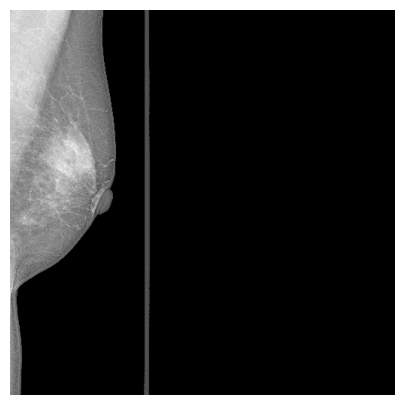

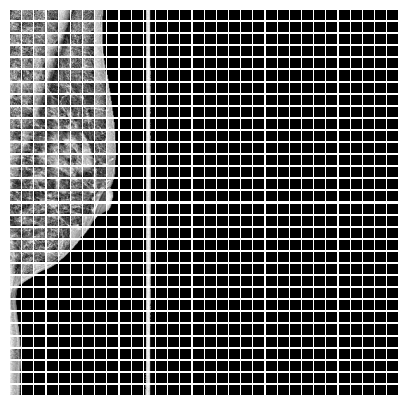

In [7]:
FILE_PATH = ('/content/mammograms512/10006_1459541791.png')

img = read_xray(FILE_PATH, img_size=(512, 512))

batch = torch.tensor(img[None])
patch_size = (16, 16)
batch_patches = patchify(batch, patch_size)

patches = batch_patches[0]
c, nh, nw, ph, pw = patches.shape

plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap="gray")
plt.axis("off")

plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j], cmap="gray")
        plt.axis("off")

In [8]:
def get_mlp(in_features, hidden_units, out_features):
    """
    Returns a MLP head
    """
    dims = [in_features] + hidden_units + [out_features]
    layers = []
    for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
        layers.append(nn.Linear(dim1, dim2))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    return nn.Sequential(*layers)

In [9]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences
    
    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.linear = nn.Linear(token_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

    def __call__(self, batch):
        batch = patchify(batch, self.patch_size)

        b, c, nh, nw, ph, pw = batch.shape

        # Flattening the patches
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        batch = torch.reshape(batch, [b, nh * nw, ph * pw * c])

        batch = self.linear(batch)
        cls = self.cls_token.expand([b, -1, -1])
        emb = batch + self.pos_emb

        return torch.cat([cls, emb], axis=1)

In [10]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        """
        Args:
            img_size: Size of the image
            patch_size: Size of the patch
            n_channels: Number of image channels
            d_model: The number of features in the transformer encoder
            nhead: The number of heads in the multiheadattention models
            dim_feedforward: The dimension of the feedforward network model in the encoder
            blocks: The number of sub-encoder-layers in the encoder
            mlp_head_units: The hidden units of mlp_head
            n_classes: The number of output classes
        """
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, dropout = 0.1, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)
        
        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax()

    def __call__(self, batch):

        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        batch = self.mlp(batch)
        output = self.output(batch)
        return output

Hyperparameters

In [11]:
img_size = (512, 512)
patch_size = (16, 16)
n_channels = 1
d_model = 1024
nhead = 4
dim_feedforward = 2048
blocks = 12
mlp_head_units = [1024, 512]
n_classes = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Data Set + Data Loader

In [12]:
class RSNADataset(Dataset):
    
    def __init__(self, df, img_path):
        self.df = df
        self.img_path = img_path
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        patient_id, image_id, cancer = self.df.iloc[idx][['patient_id', 'image_id', 'cancer']]
        file = os.path.join(self.img_path, f'{patient_id}_{image_id}.png')
        file = cv2.imread(file, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit = 15, tileGridSize=[8, 8])
        file = clahe.apply(file)
        file = file / file.max()
        X = torch.tensor(file[np.newaxis].astype('float32')).to(device)
        y = torch.tensor([cancer]).float().to(device)
        return X, y

Read Data

In [13]:
df = pd.read_csv('/content/training_data.csv')
counts = df['cancer'].value_counts()
df['weights'] = df['cancer'].apply(lambda x: 1/counts[x])

train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['cancer'])

Gather Images + Data

In [14]:
img_path = '/content/mammograms512'
num_samples = len([name for name in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, name))])
# train_samples = int(num_samples * 0.80)
# val_samples = int(num_samples * 0.20)
train_samples = 1000
val_samples = 500

train_ds = RSNADataset(train_df, img_path)
val_ds = RSNADataset(val_df, img_path)

train_sampler = WeightedRandomSampler(train_df['weights'].values, train_samples, replacement = False)
train_loader = DataLoader(train_ds, batch_size=8, sampler=train_sampler)

val_sampler = WeightedRandomSampler(val_df['weights'].values, val_samples, replacement = False)
val_loader = DataLoader(val_ds, batch_size=32, sampler=val_sampler)

Training + Validation

In [15]:
model = ViT(
    img_size = (512, 512),
    patch_size = (16, 16),
    n_channels = 1,
    d_model = 1024,
    nhead = 8,
    dim_feedforward = 1024,
    blocks = 8,
    mlp_head_units = [512, 512],
    n_classes = 1,
).to(device)

lr = 0.0001
# weight_decay = 0.0001
weight_decay = 0
optimizer = Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.BCELoss()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_metrics = {
    "bce": Loss(criterion),
    "roc_auc": ROC_AUC()
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

In [ ]:
log_interval = 10
max_epochs = 5
best_loss = float('inf')

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

pbar = ProgressBar()
pbar.attach(trainer, ['loss'])
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_loss
    evaluator.run(val_loader)
    loss = evaluator.state.metrics['bce']
    roc_auc = evaluator.state.metrics['roc_auc']
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model_vit.pt')
    print(f"Validation Results - Epoch: {trainer.state.epoch} Avg loss: {loss:.2f} AUC: {roc_auc:.2f}")
    
output_state = trainer.run(train_loader, max_epochs=max_epochs)

[1/125]   1%|           [00:00<?]

[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 1 Avg loss: 0.65 AUC: 0.50
Validation Results - Epoch: 1 Avg loss: 0.65 AUC: 0.52


[1/125]   1%|           [00:00<?]

[1/125]   1%|           [00:00<?]